# <div style="color:orange;">[Olist] Segmentation clients - Maintenance</div>

<img src="img/olist_logo.jpg" style="height: 150px;">

# <div style="color: blue" id="ch0">0. Plan du notebook</div>

1. [Imports et fonctions générales](#ch1)<br>
2. [Création du dataset final](#ch2)<br>
3. [Recherche de la fréquence de maintenance](#ch3)<br>
4. [Conclusion](#ch4)<br>

# <div style="color: blue" id="ch1">1. Imports et fonctions générales</div>

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score

In [3]:
def factorize_dataset(month, year):
    # Calcul de la date maximum à chercher dans le dataset "bulk"
    if month == 12:
        max_datetime = datetime((year + 1), 1, 1, 23, 59, 59) - timedelta(days=1)
    else:
        max_datetime = datetime(year, (month + 1), 1, 23, 59, 59) - timedelta(days=1)
    sub_df = bulk[bulk['order_purchase_timestamp'] <= max_datetime]
    # Calcul de la récence
    min_datetime = sub_df['order_purchase_timestamp'].min()
    nb_months = int(np.floor((max_datetime - min_datetime).days / 30)) + 1
    sub_df['purchase_recence'] = (sub_df['order_purchase_timestamp'] - max_datetime).dt.days
    # Regroupement du sous-dataset en plusieurs métriques
    sub_count = sub_df[['customer_unique_id', 'order_purchase_timestamp']].groupby(
        'customer_unique_id').count().reset_index().rename(columns={'order_purchase_timestamp': 'nb_orders'})
    to_sum = ['customer_unique_id', 'payment_value', 'nb_products', 'installments']
    sub_sum = sub_df.groupby('customer_unique_id').sum().reset_index().loc[:, to_sum]
    sub_sum.rename(columns={'payment_value': 'total_payment_value', 'nb_products': 'total_nb_products',
        'installments': 'total_installments'}, inplace=True)
    to_mean = ['customer_unique_id', 'delivery_delay', 'review_score']
    sub_mean = sub_df.groupby('customer_unique_id').mean().reset_index().loc[:, to_mean]
    sub_mean.rename(columns={'delivery_delay': 'mean_delivery_delay', 'review_score': 'mean_review_score'},
                    inplace=True)
    sub_max = sub_df[['customer_unique_id', 'purchase_recence']].groupby('customer_unique_id').max().reset_index()
    # Aggrégation
    res = pd.merge(sub_sum, sub_mean, how='left', on='customer_unique_id')
    res = pd.merge(res, sub_count, how='left', on='customer_unique_id')
    res = pd.merge(res, sub_max, how='left', on='customer_unique_id')
    res.drop('customer_unique_id', axis=1, inplace=True)
    # Calcul de la fréquence
    res['purchase_frequency'] = res['nb_orders'] / nb_months
    return res

In [4]:
def compute_ari(t0_month, t0_year):
    ari_df = pd.DataFrame(columns=['year_month', 'ARI_score'])
    # Paramétrage du dataset D0 et segmentation en 5 clusters
    if t0_month == 1:
        old_df = factorize_dataset(12, t0_year - 1)
    else:
        old_df = factorize_dataset(t0_month - 1, t0_year)
    scaler = StandardScaler()
    old_std = scaler.fit_transform(old_df)
    old_scaled = pd.DataFrame(old_std, columns=old_df.columns)
    km_old = KMeans(n_clusters=5, tol=1e-04, random_state=0)
    km_old_fit = km_old.fit(old_scaled)
    # Computation de l'ARI pour chaque mois jusqu'à la fin des données disponibles dans le dataset
    for annee in range(t0_year, 2019):
        m_min = 1
        m_max = 12
        if annee == 2018:
            m_max = 9
        elif annee == 2016:
            m_min = 10
        if annee == t0_year and t0_month > m_min:
            m_min = t0_month
        for mois in range(m_min, m_max + 1):
            # Paramétrage du dataset D+1 et segmentation en 5 clusters
            new_df = factorize_dataset(mois, annee)
            new_std = scaler.fit_transform(new_df)
            new_scaled = pd.DataFrame(new_std, columns=new_df.columns)
            km_new = KMeans(n_clusters=5, tol=1e-04, random_state=0)
            km_new_fit = km_new.fit(new_scaled)
            # Comparaison des prédictions pour les clusters de t+1
            y_true = km_new.labels_
            y_pred = km_old_fit.predict(new_scaled)
            mois_str = normalize_month(mois)
            # Alimentation du dataset de résultat
            ari_df = ari_df.append(dict(zip(
                ari_df.columns,
                [f"{annee}{mois_str}", adjusted_rand_score(y_true, y_pred)])), ignore_index=True)
            # D+1 devient le nouveau D0
            old_df = new_df
    return ari_df

In [5]:
def plot_ari(df, t0_month, t0_year):
    month_name = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 
                  'novembre', 'décembre']
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=df, x='year_month', y='ARI_score')
    plt.title(f"Score ARI par adjonction d'un mois à la fois à partir de {month_name[t0_month - 1]} {t0_year}")
    plt.xlabel("Année-mois")
    plt.ylabel("Score ARI")
    plt.xticks(rotation=45)
    plt.show()

In [6]:
def normalize_month(m):
    if len(str(m)) == 2:
        return f"{m}"
    else:
        return f"0{m}"

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
cus = pd.read_csv('data/olist_customers_dataset.csv')
itm = pd.read_csv('data/olist_order_items_dataset.csv')
pay = pd.read_csv('data/olist_order_payments_dataset.csv')
rev = pd.read_csv('data/olist_order_reviews_dataset.csv')
ods = pd.read_csv('data/olist_orders_dataset.csv')

*[(Retour sommaire)](#ch0)*

# <div style="color: blue" id="ch2">2. Création du dataset final</div>

In [9]:
ods[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = ods[[
    'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']].astype(
    'datetime64')
for idx, row in ods.loc[
    (ods['order_status'] == 'delivered') & (ods['order_delivered_customer_date'].isna())].iterrows():
    ods.loc[ods['order_id'] == row['order_id'], 'order_delivered_customer_date'] = row['order_estimated_delivery_date']
ods.assign(delivery_delay=0)
ods.loc[~ods['order_delivered_customer_date'].isna(), 'delivery_delay'] = ((ods.loc[
    ~ods['order_delivered_customer_date'].isna(), 'order_delivered_customer_date'] - ods.loc[
    ~ods['order_delivered_customer_date'].isna(), 'order_estimated_delivery_date']).dt.days).astype('int')
ods_light = ods[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_delay']]

In [10]:
pay_sum = pay[['order_id', 'payment_sequential', 'payment_value']].groupby('order_id').sum().reset_index()
pay_sum.rename(columns={'payment_sequential': 'installments'}, inplace=True)
ods_pay = pd.merge(ods_light, pay_sum, how='left', on='order_id')
ods_pay['payment_value'] = ods_pay['payment_value'].fillna(0)

In [11]:
rev_mean = rev.groupby('order_id').mean().reset_index().loc[:, ['order_id', 'review_score']]
ods_pay_rev = pd.merge(ods_pay, rev_mean, how='left', on='order_id')

In [12]:
itm_max = itm[['order_id', 'order_item_id']].groupby('order_id').max().reset_index()
opri = pd.merge(ods_pay_rev, itm_max, how='left', on='order_id')
opri.rename(columns={'order_item_id': 'nb_products'}, inplace=True)

In [13]:
opri['installments'] = opri['installments'].fillna(1)
opri['nb_products'] = opri['nb_products'].fillna(1)
simple = SimpleImputer(strategy='mean')
opri[['review_score']] = simple.fit_transform(opri[['review_score']])
simple = SimpleImputer(strategy='median')
opri[['delivery_delay']] = simple.fit_transform(opri[['delivery_delay']])

In [14]:
bulk = pd.merge(cus[['customer_id', 'customer_unique_id']], opri, how='left', on='customer_id')
bulk.drop(['order_id', 'customer_id'], axis=1, inplace=True)

In [15]:
bulk.head()

,customer_unique_id,order_purchase_timestamp,delivery_delay,installments,payment_value,review_score,nb_products
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,-11.0,1.0,146.87,4.0,1.0
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,-8.0,1.0,335.48,5.0,1.0
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,1.0,1.0,157.73,5.0,1.0
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,-13.0,1.0,173.30,5.0,1.0
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,-6.0,1.0,252.25,5.0,1.0


*[(Retour sommaire)](#ch0)*

# <div style="color: blue" id="ch3">3. Recherche de la fréquence de maintenance</div>

### T0 = Janvier 2017

In [17]:
t_2017_01 = compute_ari(1, 2017)

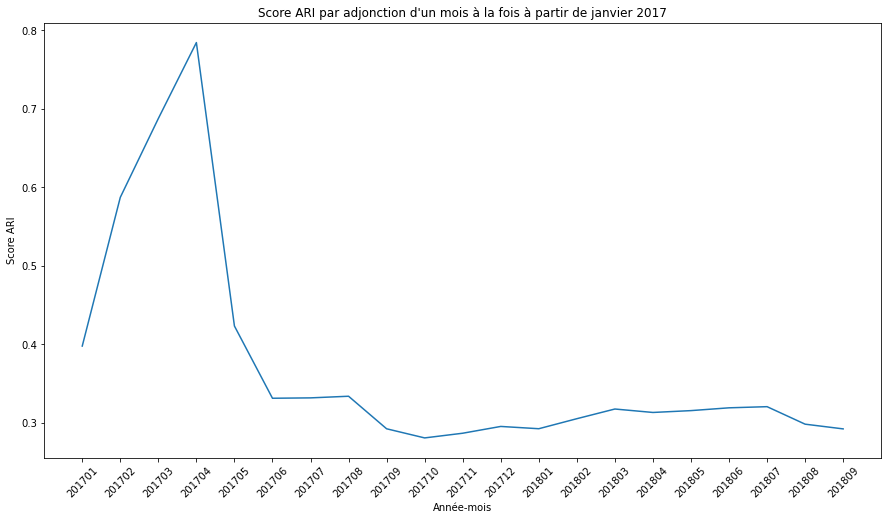

In [19]:
plot_ari(t_2017_01, 1, 2017)

### T0 = Avril 2017

In [28]:
t_2017_04 = compute_ari(4, 2017)

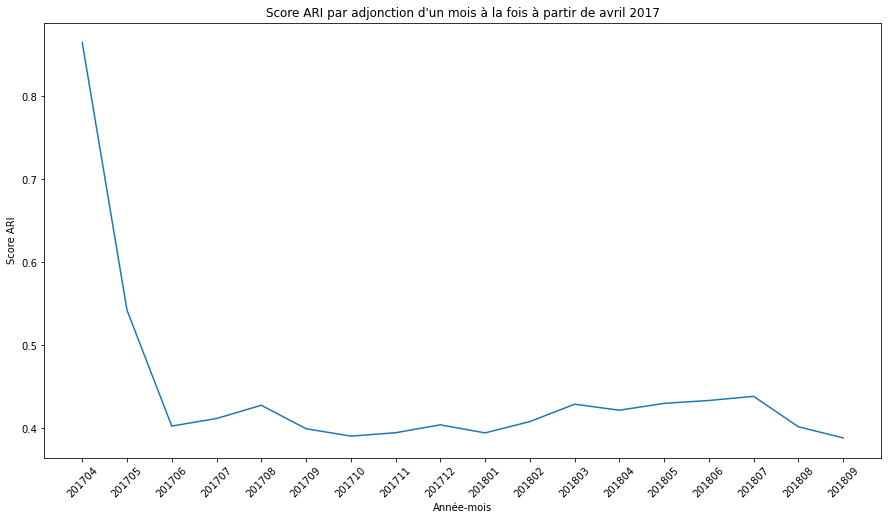

In [29]:
plot_ari(t_2017_04, 4, 2017)

### T0 = Mai 2017

In [15]:
t_2017_05 = compute_ari(5, 2017)

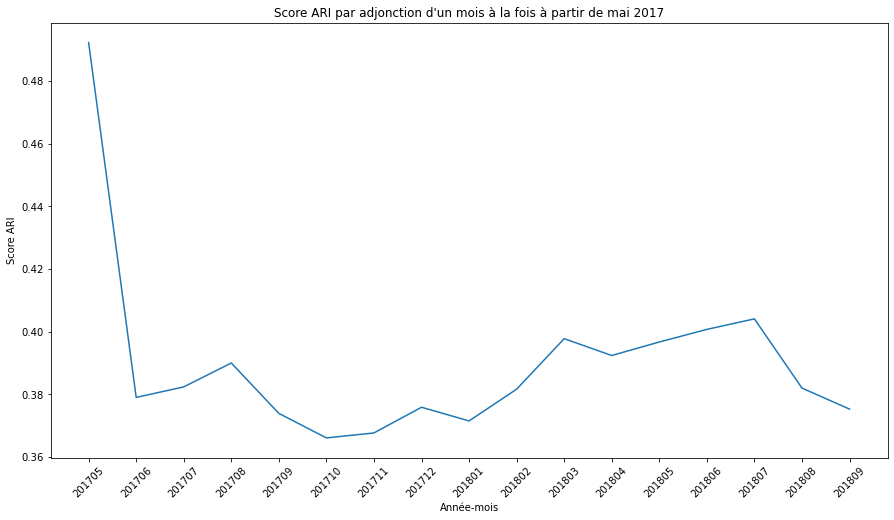

In [16]:
plot_ari(t_2017_05, 5, 2017)

### T0 = Juin 2017

In [17]:
t_2017_06 = compute_ari(6, 2017)

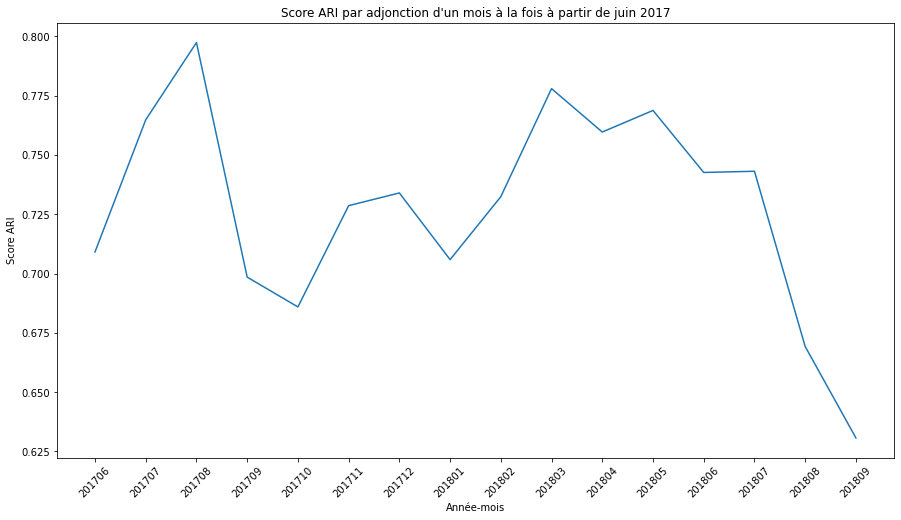

In [18]:
plot_ari(t_2017_06, 6, 2017)

### T0 = Juillet 2017

In [34]:
t_2017_07 = compute_ari(7, 2017)

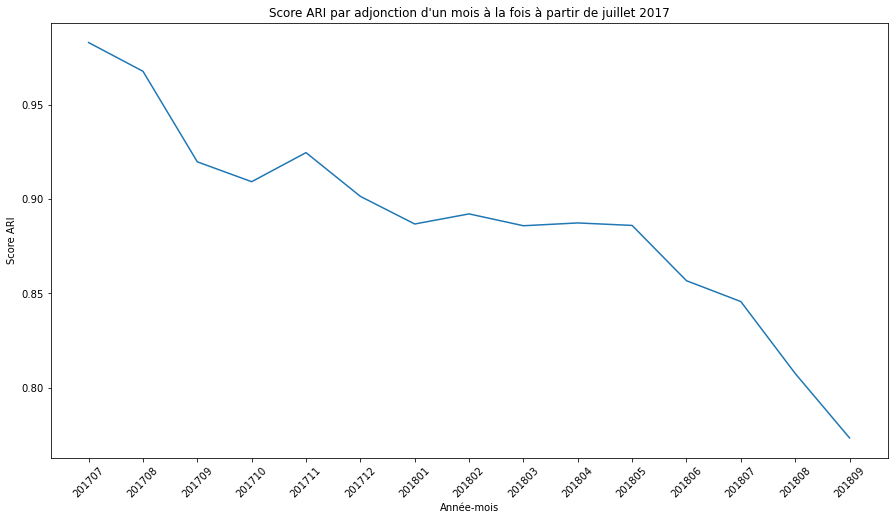

In [35]:
plot_ari(t_2017_07, 7, 2017)

### T0 = Octobre 2017

In [22]:
t_2017_10 = compute_ari(10, 2017)

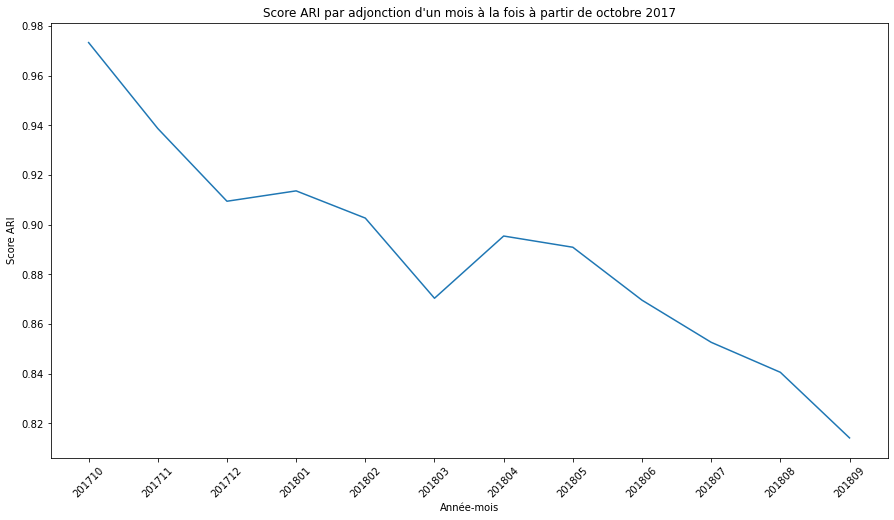

In [23]:
plot_ari(t_2017_10, 10, 2017)

### T0 = Janvier 2018

In [24]:
t_2018_01 = compute_ari(1, 2018)

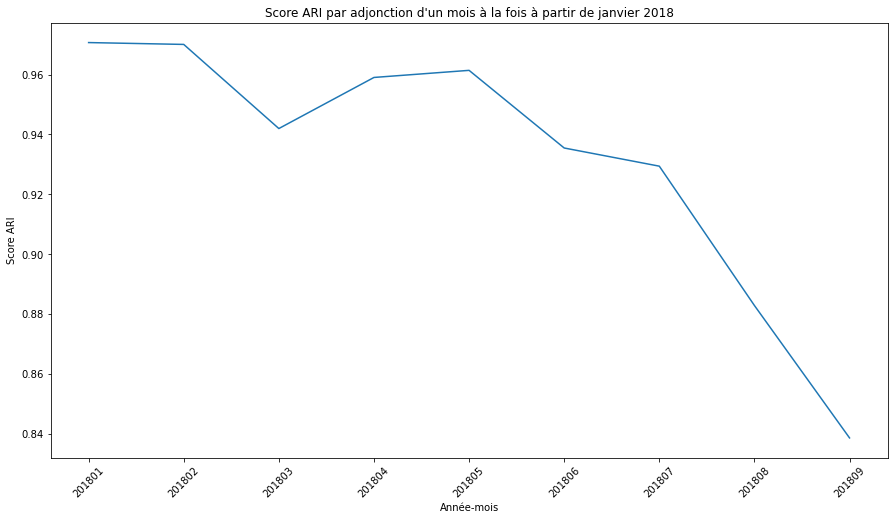

In [25]:
plot_ari(t_2018_01, 1, 2018)

### T0 = Avril 2018

In [36]:
t_2018_04 = compute_ari(4, 2018)

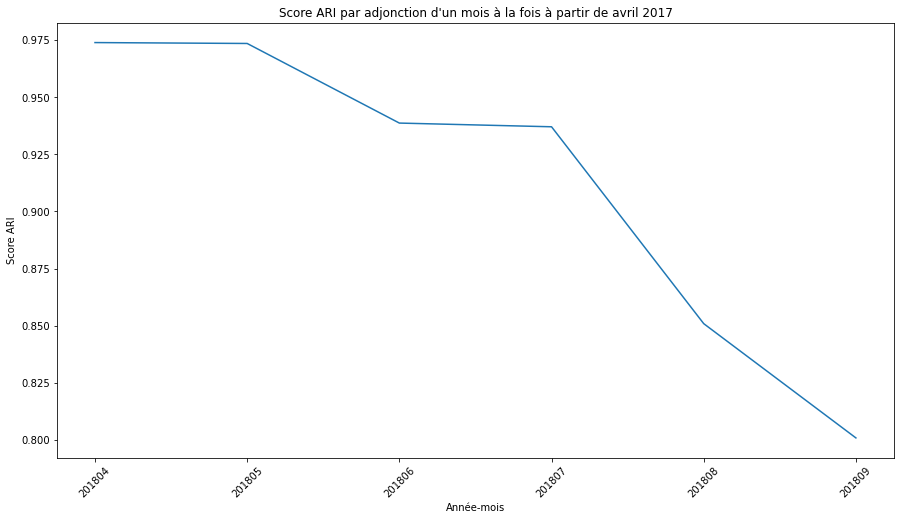

In [37]:
plot_ari(t_2018_04, 4, 2017)

*[(Retour sommaire)](#ch0)*

# <div style="color: blue" id="ch4">4. Conclusion</div>

Après avoir conduit plusieurs essais, nous constatons que la date d'initialisation (ici appelée `T0`) influe fortement sur le score ARI obtenu, des résultats acceptables étant obtenus dans notre cas pour `T0` = Juillet 2017 et suivants.

Lorsqu'on regarde la courbe d'activité d'Olist, on comprend aisément pourquoi :

<img src="img/nb_orders_distribution.png">

Deux raisons principales :
1. L'activité de la plateforme Olist a débuté fin 2016, et a connu une croisance fulgurante qui n'a atteint un premier seuil d'inflexion qu'entre mai et juillet 2017
2. Les données avant juillet 2017 sont trop peu nombreuses pour être significatives

Passé juillet 2017, quelque soit le `T0` choisi, nous pouvons constaté le même phénomène, à savoir une relative stabilité suivie d'une décroissance rapide du score ARI à partir de juillet 2018.

Nous recommanderons donc ici une fréquence de maintenance minimale de 12 mois. Cependant, Olist en étant encore à ses débuts, il pourrait être intéressant de procéder à des réévaluation plus fréquentes, ou encore à des études one-shot sur une période spécifique afin de mesurer le succès de campagnes marketing ciblées.

*[(Retour sommaire)](#ch0)*